In [141]:
import numpy as np
import pandas as pd
import scipy as sc
from sklearn import decomposition
from tqdm import tqdm
import gc
from matplotlib import pyplot as plt
import seaborn as sns

In [133]:
def _dim_reduction(df, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack', process_cohorts=False):
    # method: PCA
    gene_columns = [_col for _col in df.columns if 'GenX' in _col]
    #print("There are {} features to reduce...woohooo".format(len(gene_columns)))
    cohorts = df.batch_number.unique().tolist()
    ind = df.index
    non_gene_columns = [_col for _col in df.columns if 'GenX' not in _col]
    red_data_dict = {}
    if process_cohorts:
        for _cohort in cohorts:
            ch = df['batch_number']==_cohort
            X = df.loc[ch, gene_columns]
            if X.shape[0]>min_samples:
                # PCA 3
                reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
                # put components in a dictionary with cohort as key
                X_red = reducer.fit_transform(X)
                #
                red_data_dict[_cohort] = {}
                red_data_dict[_cohort]['data'] = X_red
                red_data_dict[_cohort]['reducer'] = reducer
    print("Running reducer on all samples..")
    reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
    X = df.loc[:, gene_columns]
    X_red = reducer.fit_transform(X)
    
    red_cols = ['red_'+str(i) for i in range(0,n_comp)]
    df_red = pd.DataFrame(data=X_red, index=ind, columns=red_cols)
    
    red_data_dict['ALL'] = {}
    red_data_dict['ALL']['data'] = df[non_gene_columns].merge(df_red, how='inner', left_index=True, right_index=True)
    red_data_dict['ALL']['reducer'] = reducer
    
    
    return red_data_dict

# Load in data

In [9]:
RNA_ComBat_param = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/RNAexpression_combat_primaryonly_gender_param.csv",
                               sep="\t", engine="python")
#RNA_ComBat_param.columns = [_col.replace("\"", "").replace(".", "-") for _col in RNA_ComBat_param.columns.tolist()]
#RNA_ComBat_param.index = rename_index = [_ind.replace("\"", "") for _ind in RNA_ComBat_param.index.tolist()]
###
RNA_ComBat_nonparam = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/RNAexpression_combat_primaryonly_gender_nonparam.csv",
                               sep="\t", engine="python")
#RNA_ComBat_nonparam.columns = [_col.replace("\"", "").replace(".", "-") for _col in RNA_ComBat_nonparam.columns.tolist()]
#RNA_ComBat_nonparam.index = rename_index = [_ind.replace("\"", "") for _ind in RNA_ComBat_nonparam.index.tolist()]
###
RNA_LSquantile = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/RNAexpression_quantile_LS_.csv"
                                    , sep=",", engine="python")
###
RNA_Raw = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/gene_raw.csv", 
                      sep="\t", 
                      engine="python")
# RNAexpression_LSstandard_shifted
RNA_LSstandard = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/RNAexpression_LSstandard_shifted.csv"
                                    , sep=",", engine="python")

In [11]:
RNA_ComBat_param.drop(['chr', 'gene', 'start', 'stop', 'strand'], axis=1, inplace=True)
RNA_ComBat_nonparam.drop(['chr', 'gene', 'start', 'stop', 'strand'], axis=1, inplace=True)

RNA_LSstandard.set_index('patient_nr', inplace=True)
RNA_LSquantile.set_index('patient_nr', inplace=True)
RNA_Raw.set_index('GenX', inplace=True)

RNA_ComBat_nonparam.set_index('GenX', inplace=True)
RNA_ComBat_param.set_index('GenX', inplace=True)

# Add phenotypical data and transpose if necessary

In [33]:
RNA_Raw = RNA_Raw.copy().T
gc.collect()

RNA_ComBat_param = RNA_ComBat_param.copy().T
gc.collect()

RNA_ComBat_nonparam = RNA_ComBat_nonparam.copy().T
gc.collect()

7

# load phenotypical data 

In [35]:
pheno_small = pd.read_csv("../../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_small = pheno_small.copy().loc[pheno_small["Sample Type"]=='Primary Tumor']
pheno_small.set_index('SampleID', inplace=True)
pheno_large = pd.read_csv("../../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)
pheno_large['SampleID'] = pheno_large.index
pheno_large = pheno_large.copy().loc[pheno_large["sample_type.samples"]=='Primary Tumor']


In [83]:
# Gender (small) Pack Years (small), Smoking Status (small), Diagnosis (small), Age At Diagnosis (Days) (small)
# batch_number (large), histological_type (large), cigarettes_per_day.exposures (large), tissue_or_organ_of_origin.diagnoses (large)
# race.demographic

pheno = pheno_small[['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis', 'Age At Diagnosis (Days)']]\
                    .merge(pheno_large[['batch_number', 'histological_type', 'cigarettes_per_day.exposures',
                                       'tissue_or_organ_of_origin.diagnoses', 'race.demographic']], how='inner',
                                       left_index=True, right_index=True)

In [38]:
df_list = [RNA_ComBat_param, RNA_ComBat_nonparam, RNA_ComBat_LSquantile, RNA_ComBat_LSstandard, RNA_Raw]


In [100]:
GenX_columns = [_col for _col in RNA_LSquantile.columns if 'GenX_' in _col]
RNA_LSquantile = RNA_LSquantile.copy().loc[:, GenX_columns]

GenX_columns = [_col for _col in RNA_LSstandard.columns if 'GenX_' in _col]
RNA_LSstandard = RNA_LSstandard.copy().loc[:, GenX_columns]

In [110]:
RNA_ComBat_param.columns = ['GenX_'+_col for _col in RNA_ComBat_param.columns]
RNA_ComBat_nonparam.columns = ['GenX_'+_col for _col in RNA_ComBat_nonparam.columns]
RNA_Raw.columns = ['GenX_'+_col for _col in RNA_Raw.columns]

In [168]:
RNA_LSquantile = RNA_LSquantile.copy().dropna()

In [169]:
data_dict = {'ComBat_param': RNA_ComBat_param, 
             'ComBat_nonparam': RNA_ComBat_nonparam,
             'LS_standard': RNA_LSstandard,
             'LS_quantile': RNA_LSquantile,
             'raw': RNA_Raw}

In [170]:
for _key in data_dict.keys():
    data_dict[_key] = data_dict[_key].merge(pheno, how='left', left_index=True, right_index=True)

# Get principal components

In [171]:
data_reduced = {}
n_components = 50

for _key in data_dict.keys():
    print("Processing {} data: ".format(_key))
    data_reduced[_key] = _dim_reduction(data_dict[_key], min_samples=10, n_comp=n_components, method='PCA', pc_solver='arpack')

Processing ComBat_param data: 
Running reducer on all samples..
Processing ComBat_nonparam data: 
Running reducer on all samples..
Processing LS_standard data: 
Running reducer on all samples..
Processing LS_quantile data: 
Running reducer on all samples..
Processing raw data: 
Running reducer on all samples..


# Statistical analysis

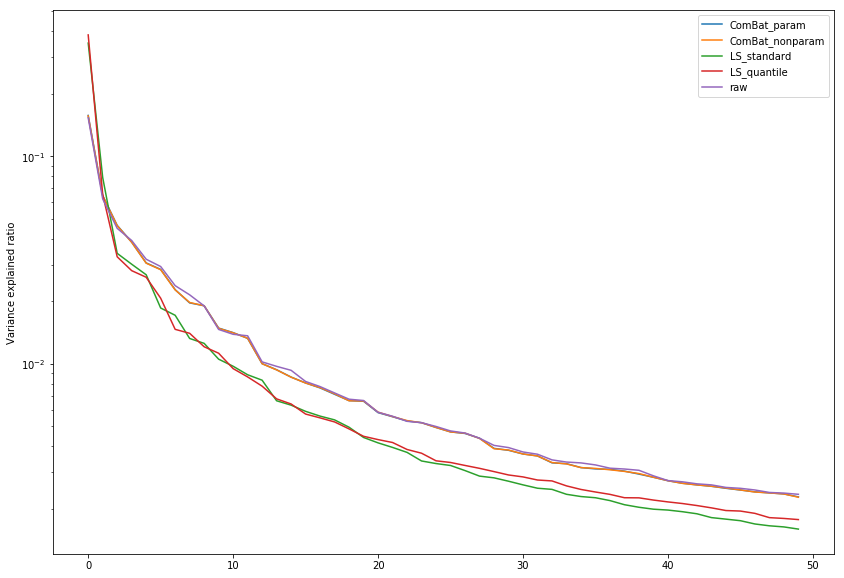

In [190]:
fig, ax = plt.subplots(figsize=(14,10))
for _key in data_reduced.keys():
    plt.plot(data_reduced[_key]['ALL']['reducer'].explained_variance_ratio_, label=_key)
    plt.semilogy()
    plt.ylabel('Variance explained ratio')
    plt.legend()

PC's for methylation data:LS_quantile


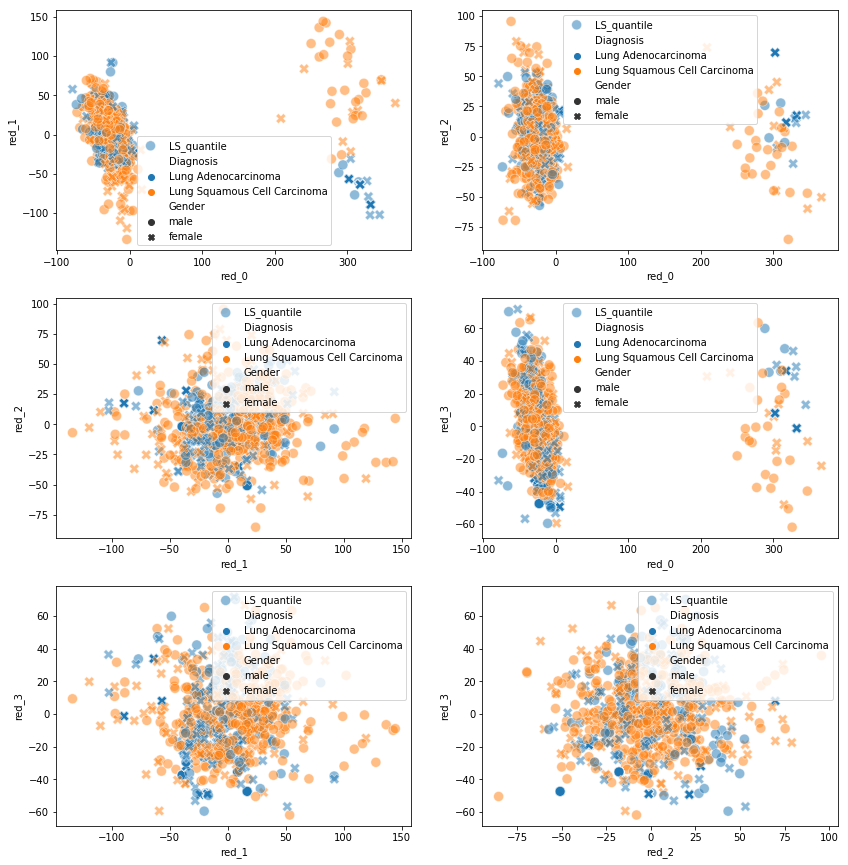

In [172]:
# check PCA, for first components, color by cancer diagnosis.
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(14,15))
key = 'LS_quantile' # ComBat_param,ComBat_nonparam, LS_standard,raw
color_by = 'Diagnosis' # batch_number, Gender, Diagnosis
size_by = None
def_size = 100
style_by = 'Gender'
print('PC\'s for methylation data:{}'.format(key))
sns.scatterplot(x='red_0', y='red_1', data=data_reduced[key]['ALL']['data'],
                label=key, alpha=0.5, hue=color_by, ax=ax[0,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_0', y='red_2', data=data_reduced[key]['ALL']['data'],
                label=key, alpha=0.5, hue=color_by, ax=ax[0,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_1', y='red_2', data=data_reduced[key]['ALL']['data'],
                label=key, alpha=0.5, hue=color_by, ax=ax[1,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_0', y='red_3', data=data_reduced[key]['ALL']['data'],
                label=key, alpha=0.5, hue=color_by, ax=ax[1,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_1', y='red_3', data=data_reduced[key]['ALL']['data'],
                label=key, alpha=0.5, hue=color_by, ax=ax[2,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_2', y='red_3', data=data_reduced[key]['ALL']['data'],
                label=key, alpha=0.5, hue=color_by, ax=ax[2,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)

In [ ]:
# batch dissimilarity


# Write out RNA data with GenX names separated

In [88]:
GenX = [tuple(_genx.split(".")) for _genx in RNA_ComBat_param.index.tolist()]
GenX_dictlist = [{'gene': _t[0], 
                  'chr': _t[1], 
                  'start': _t[2],
                  'stop': _t[3],
                  'strand': _t[4],
                  'GenX': ".".join(_t)} for _t in GenX]
GenX_df = pd.DataFrame(GenX_dictlist)

RNA_ComBat_param = RNA_ComBat_param.copy().merge(GenX_df, how='left', left_index=True, right_on='GenX')
RNA_ComBat_param.to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/RNAexpression_combat_primaryonly_gender_param.csv",
                       sep="\t", header=True, index=False)

In [99]:
RNA_ComBat_nonparam = RNA_ComBat_nonparam_T.T
GenX = [tuple(_genx.split(".")) for _genx in RNA_ComBat_nonparam.index.tolist()]
GenX_dictlist = [{'gene': _t[0], 
                  'chr': _t[1], 
                  'start': _t[2],
                  'stop': _t[3],
                  'strand': _t[4],
                  'GenX': ".".join(_t)} for _t in GenX]
GenX_df = pd.DataFrame(GenX_dictlist)

RNA_ComBat_nonparam = RNA_ComBat_nonparam.copy().merge(GenX_df, how='left', left_index=True, right_on='GenX')
RNA_ComBat_nonparam.to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/RNAexpression_combat_primaryonly_gender_nonparam.csv",
                       sep="\t", header=True, index=False)
del RNA_ComBat_nonparam
gc.collect()

21